# ADS Thesis Project - SVM Model Goat

**Authors: Marion Späth (2772981)**


This notebook documents the Boosting Models for goat herders.
The datasets have been created in the R file "ML PREPARATIONS.Rmd".

In [1]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import os
import pickle
import shap
import matplotlib.pyplot as plt


Import Datasets

In [2]:
pd.set_option('display.max_columns', None) # show all columns in output

# set working directory
os.chdir('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/ML_training')

# load train and test data (previously created in the ElasticNet notebook)
train_goat = pd.read_csv("train_goat_df.csv")
test_goat = pd.read_csv("test_goat_df.csv")
test_goat.head(2)

,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,educ_recoded_constant_num,eng_language,expend,irrigated_land_bin,cs_cs_diff_post_goat,cs_cs_ratio_post_goat,number_minors,educ_child_recoded,educ_child_recodedNUMERIC,activity_child_recoded,household_description,number_adults,main_info_source_recoded,religion_recoded,owns_phone,household_moved,why_not_purchase_recoded,know_vip,trust_vip,age_constant_z,number_adults_z,number_minors_z,educ_child_z,educ_adult_z,cs_diff_log,resid_mixed
0,4,4,No,35,Yes,No,Never attended,1,No,0,0,-53.165897,0.0,3,Elementary,7,Student,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,-0.488589,-0.191439,-0.140337,0.922786,-0.474056,3.992052,-0.781516
1,12,4,No,30,No,No,Never attended,1,No,0,0,-115.108932,0.0,3,Never attended school,0,Working with Livestock,Fully settled: The whole of the household (all...,3,Interpersonal Sources,Christian,0,Yes,Lack of Awareness or Understanding,No,No,-0.786820,0.582578,-0.140337,-0.899432,-0.474056,4.754529,-0.050775


# Original Model with Education as a Categorical Variable

### Prepare Datasets for Models

Create dummies for categorical variables and split X and Y values for both test and train data.

In [3]:
# Prepare categorical variables but creating dummies
train_goat = pd.get_dummies(train_goat, drop_first='True')
test_goat = pd.get_dummies(test_goat, drop_first='True')

# Prepare X and Y training sets for models
X_goat = train_goat.copy
X_goat = train_goat.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_goat", "cs_cs_ratio_post_goat", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults", 
                              "number_minors", "age_constant", "educ_child_z", "educ_adult_z", "cs_diff_log"], axis=1)

Y_goat = train_goat["resid_mixed"]

X_goat_TEST = test_goat.copy
X_goat_TEST = test_goat.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_goat", "cs_cs_ratio_post_goat", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults",
                                   "number_minors", "age_constant", "educ_child_z", "educ_adult_z", "cs_diff_log"], axis=1)

Y_goat_TEST = test_goat["resid_mixed"]

#### Set Up Hyperparameters and Performance Indicators

Prepare cross-validation using grid search including all available hyperparameters and specifying performance metrics to incluede the (negative) mean squared error, (negative) mean absolute error, and R Squared. Sklearn calculate the negative values so that the interpretation of "the higher the better" is valid across all performance metrics.

In [4]:
%%time
# Align columns in test set
#X_goat_TEST_encoded = X_goat_TEST_encoded.reindex(columns=X_goat_encoded.columns, fill_value=0)

# Define SVM model
svr = SVR()

# Define parameter grid for randomized search
param_grid = {
    'C': np.logspace(-2, 2, 20),            # regularization strength
    'epsilon': np.linspace(0.01, 1.0, 20),  # tolerance for error
    'kernel': ['rbf', 'linear', 'poly'],            # two common kernels for regression
    'gamma': ['scale', 'auto']             # kernel coefficient
}

# Define custom scorer for MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Define 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform randomized search
svr = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_grid,
    n_iter=200,
    scoring={'mae': mae_scorer, 'r2': 'r2', 'mse': 'neg_mean_squared_error'},
    refit='mse',  # Refit the best model based on MAE
    cv=cv,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

#svr.fit(X_goat, Y_goat)

CPU times: total: 0 ns
Wall time: 1.01 ms


Save model

In [ ]:
# Pickle the model
#with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/'+'svr_m1_goatv1.pickle', 'wb') as to_write:
#    pickle.dump(svr, to_write)

Read in model. Extract best hyperparameter specifications and best model performance.

In [5]:
# Read in pickled model (refit on mae)
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/' + 'svr_m1_goatv1.pickle', 'rb') as to_read:
    svrm1v1 = pickle.load(to_read)

print("Best hyperparameters:\n", svrm1v1.best_params_ , "\n")
print("Performance based on best hyperparameter specification:\n", svrm1v1.best_score_)

Best hyperparameters:
 {'kernel': 'linear', 'gamma': 'scale', 'epsilon': 0.9478947368421053, 'C': 0.01} 

Performance based on best hyperparameter specification:
 -1.909475263043997


### Make Predictions on Test Set and Get Performance Metrics on Test Set

In [28]:
# 3. Predict on the test set
y_predm1v1 = svrm1v1.predict(X_goat_TEST)

# 4. Evaluate performance
mae = mean_absolute_error(Y_goat_TEST, y_predm1v1)
mse = mean_squared_error(Y_goat_TEST, y_predm1v1)
r2  = r2_score(Y_goat_TEST, y_predm1v1)

print(f"Test Set Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE):  {np.sqrt(mse):.4f}")
print(f"R-squared (R²):            {r2:.4f}")

Test Set Performance:
Mean Absolute Error (MAE): 1.0311
Root Mean Squared Error (RMSE):  1.3697
R-squared (R²):            0.0100


## SHAP

### Investigate Shapely Values

In [7]:
# for proper variable names
labels = {
  "activity_child_recodedWorking": "Child's Activity: Working (Ref: House/Domestic Work)",
  "trust_vip_Yes" : "Trust in VIP (Ref: No)",
  "know_vip_Yes" : "Knows VIP (Ref: No)",
  "educ_recoded_constant_Elementary" : "Adult's Education: Elementary (Ref: Adult Education)",
  "agric_land_Yes" : "Owns Agricultural Land (Ref: No)",
  "activity_child_recoded_Student" : "Child's Activity: Student (Ref: House/Domestic Work)",
  "eng_language_Yes" : "English Language (Ref: No)",
  "why_not_purchase_recoded_Financial, Practical, and Situational Constraints" : "Reason Non-Purchase: Financial, Practical, and Situational Constraints (Ref: Bought Insurance)",
  "activity_child_recoded_Working with Livestock" : "Child's Activity: Livestock Work (Ref: House/Domestic Work)",
  "educ_recoded_constant_Nursery" : "Adult's Education: Nursery  (Ref: Adult Education)",
  "number_minors_z" : "Number of Minors in HH (z)",
  "number_adults_z" : "Number of Adults in HH (z)",
  "owns_phone" : "Owns Phone (Ref: No)",
  "religion_recoded_Traditional/Wakefata" : "Religion: Traditional/Wakefata (Ref: Christian)",
  "religion_recoded_Muslim" : "Religion: Muslim (Ref: Christian)",
  "main_info_source_recoded_Professional and Organizational Sources" : "Info Source: Professional and Organizational Sources (Ref: Interpersonal Sources)",
  "household_moved_Yes" : "Household Moved (Ref: No)",
  "why_not_purchase_recoded_Lack of Awareness or Understanding" : "Reason Non-Purchase: Lack of Awareness / Understanding (Ref: Bought Insurance)",
  "main_info_source_recoded_Media, Community-Based, and Survey Sources" : "Info Source: Media, Community-Based, and Survey Sources  (Ref: Interpersonal Sources)",
  "household_description_Partially settled: Some members of the household are permanently settled and others move around in order to herd their animals" : "Household Partially Settled (Ref: Fully Settled)",
  "household_description_Not settled: The whole household moves around in order to herd the animals" : "Household Not Settled  (Ref: Fully Settled)",
  "age_constant_z" : "Age (z)",
  "educ_child_recoded_Never attended school" : "Child's Education: Never atteneded School (Ref: Elementary)",
  "expend" : "Expend (Ref: No)",
  "afm_language_Yes" : "Afm Language (Ref: No)",
  "amh_language_Yes" : "Amh Language (Ref: No)",
  "educ_recoded_constant_Never attended" : "Adult's Education: Never attended (Ref: Adult Education)",
  "activity_child_recoded_Not working" : "Child's Activity: Not Working (Ref: House/Domestic Work)",
  "educ_child_recoded_Secondary" : "Child's Education: Secondary School (Ref: Elementary)",
  "irrigated_land_bin" : "Irrigated Land (Ref: No)",
  "why_not_purchase_recoded_Distrust or Negative Perception" : "Reason Non-Purchase: Distrust or Negative Perception (Ref: Bought Insurance)",
  "educ_recoded_constant_Secondary and Higher" : "Adult's Education: Secondary and Higher (Ref: Adult Education)",
  "educ_child_recoded_Other" : "Child's Education: Other (Ref: Elementary)",
  "activity_child_recoded_Working" : "Child's Activity: Working (Ref: House/Domestic Work)",
}

In [8]:
# Extract best model
best_model = svrm1v1.best_estimator_
best_model

# Set Up Explainer
X_sample = X_goat.sample(n=100, random_state=0) # limit to random sample for runtime reasons
explainer = shap.KernelExplainer(best_model.predict, X_sample)

In [9]:
# Compute SHAP values
shap_values = explainer.shap_values(X_sample)


  0%|          | 0/100 [00:00<?, ?it/s]

c:\anaconda_custom\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


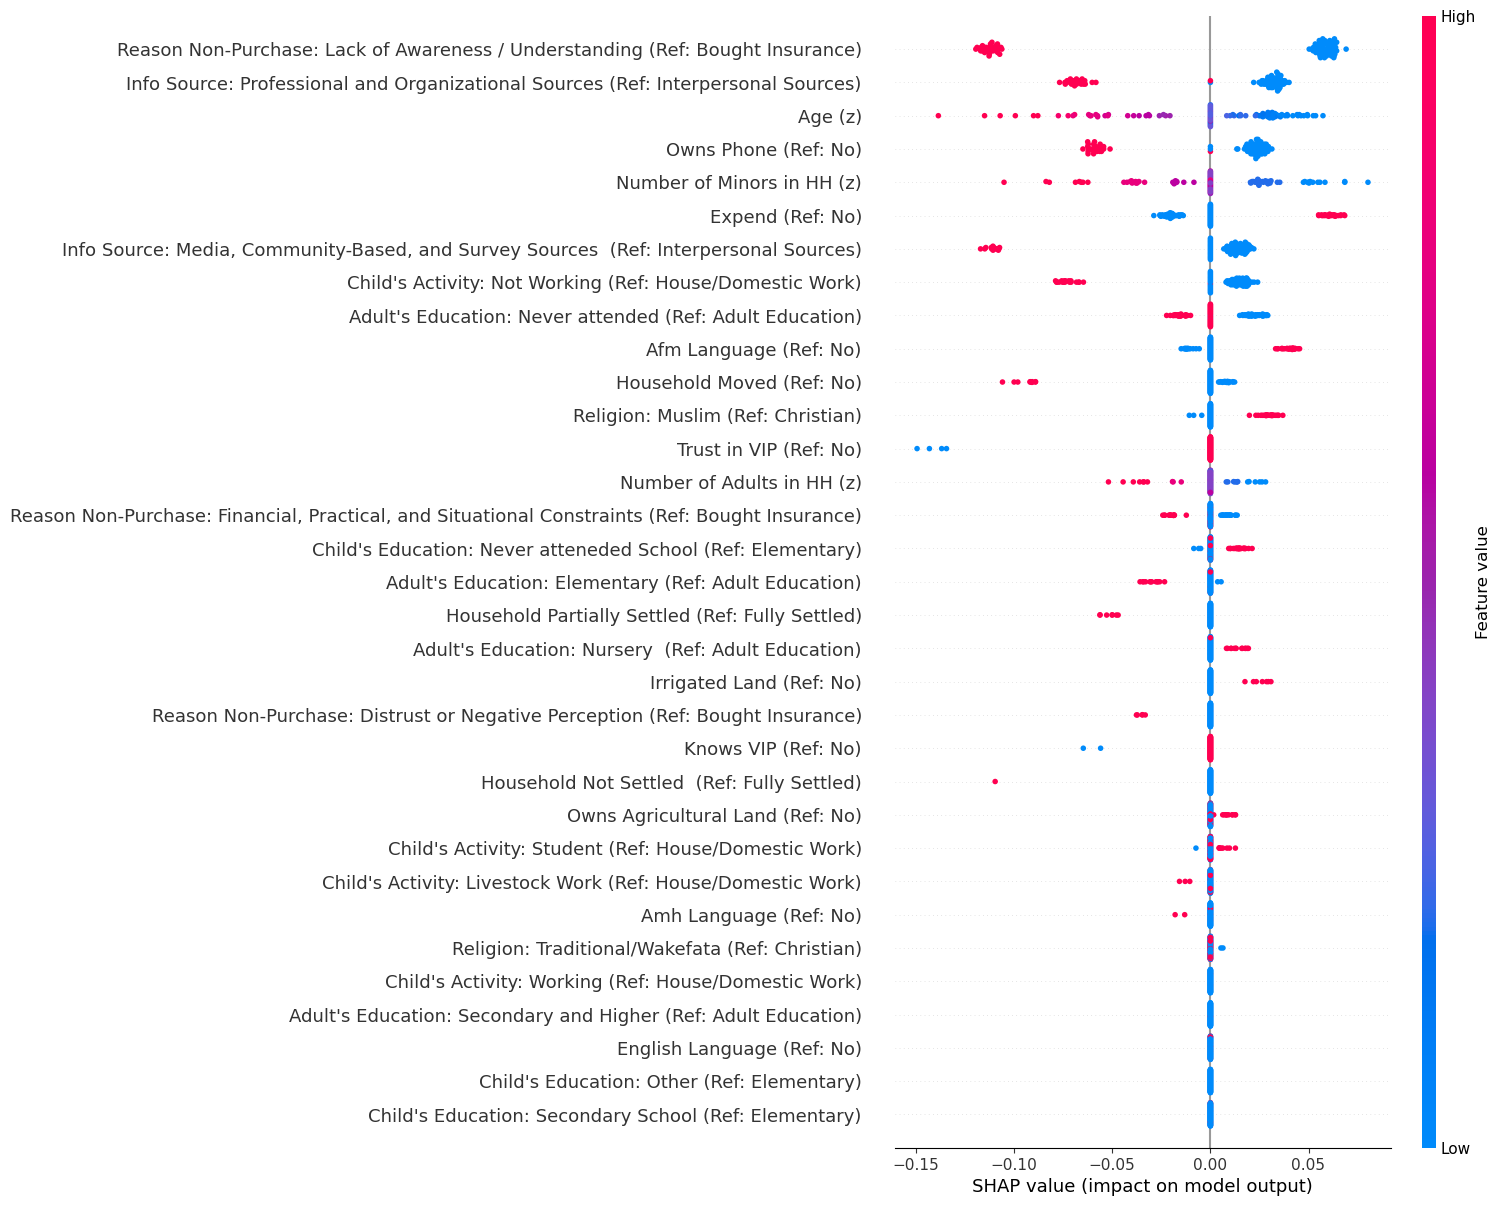

In [10]:
X_sample_renamed = X_sample.rename(columns=labels)

#  Plot SHAP summary for all variables
shap.summary_plot(
    shap_values,
    X_sample_renamed,
    plot_type="dot",
    max_display=100
)

Limit to Top 10 variables

c:\anaconda_custom\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


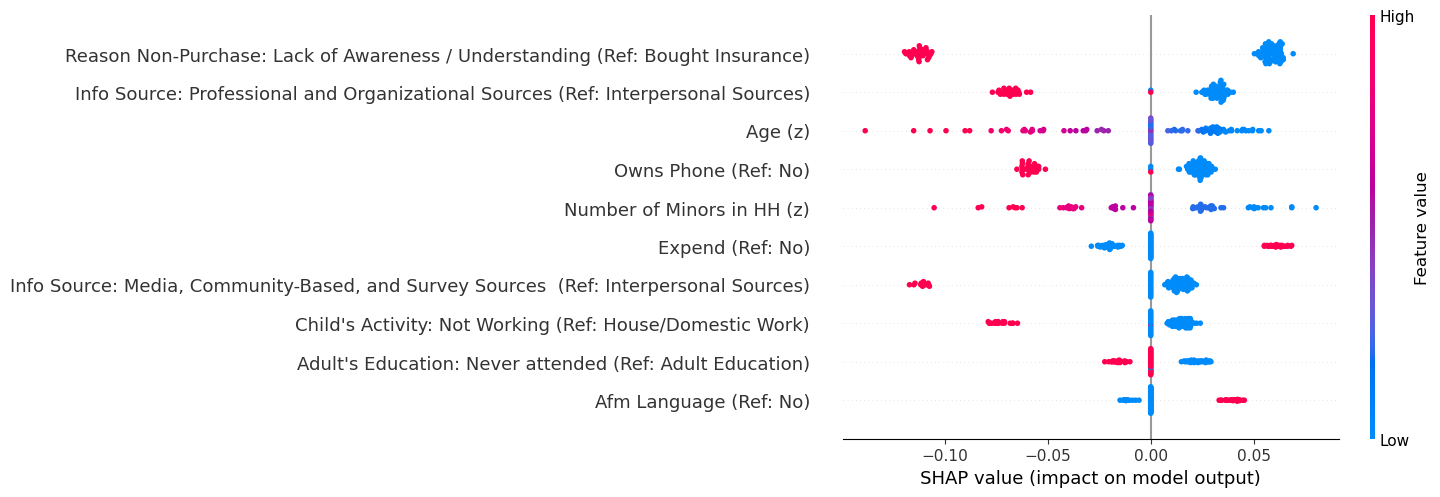

In [11]:
shap.summary_plot(
    shap_values,
    X_sample_renamed,
    plot_type="dot",
    max_display=10
)

## Aggregate Dummy Variables to Original Categorical Feature

The absolute values are summed up to their original, broader variable. Absolute values are used so as to get the variables' strength and avoid positive and negative effects to cancel each other out.

In [12]:
# create mapping of dummies to variable
dummy_groups = {
    "Religion": ["Religion: Muslim (Ref: Christian)", "Religion: Traditional/Wakefata (Ref: Christian)"],
    "Adult's Education": ["Adult's Education: Elementary (Ref: Adult Education)", "Adult's Education: Never attended (Ref: Adult Education)", "Adult's Education: Nursery  (Ref: Adult Education)", "Adult's Education: Secondary and Higher (Ref: Adult Education)"],
    "Child's Education": ["Child's Education: Never atteneded School (Ref: Elementary)", "Child's Education: Other (Ref: Elementary)", "Child's Education: Secondary School (Ref: Elementary)"],
    "Child's Activity": ["Child's Activity: Not Working (Ref: House/Domestic Work)", "Child's Activity: Student (Ref: House/Domestic Work)", "Child's Activity: Working (Ref: House/Domestic Work)", "Child's Activity: Livestock Work (Ref: House/Domestic Work)"],
    "Household Status": ["Household Not Settled  (Ref: Fully Settled)", "Household Partially Settled (Ref: Fully Settled)"],
    "Main Information Source": ["Info Source: Media, Community-Based, and Survey Sources  (Ref: Interpersonal Sources)", "Info Source: Professional and Organizational Sources (Ref: Interpersonal Sources)"],
    "Reason Non-Purchase": ["Reason Non-Purchase: Financial, Practical, and Situational Constraints (Ref: Bought Insurance)", "Reason Non-Purchase: Lack of Awareness / Understanding (Ref: Bought Insurance)", 
                            "Reason Non-Purchase: Distrust or Negative Perception (Ref: Bought Insurance)"],
    "Trust in VIP": ["Trust in VIP (Ref: No)"],
    "Knows VIP": ["Knows VIP (Ref: No)"],
    "Expend" : ["Expend (Ref: No)"],
    "Irrigated Land": ["Irrigated Land (Ref: No)"],
    "Owns Phone": ["Owns Phone (Ref: No)"],
    "Afm Language": ["Afm Language (Ref: No)"],
    "Owns Agricultural Land" : ["Owns Agricultural Land (Ref: No)"],
    "Amh Language": ["Amh Language (Ref: No)"],
    "English Language": ["English Language (Ref: No)"],
    "Household Moved" : ["Household Moved (Ref: No)"]                             
}

# Convert SHAP values to DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_sample_renamed.columns)

# Aggregate SHAP values by summing dummy columns
shap_agg = pd.DataFrame(index=shap_df.index)
for group_name, dummy_cols in dummy_groups.items():
    shap_agg[group_name] = shap_df[dummy_cols].abs().sum(axis=1)

# 4. Add remaining non-dummy columns
flattened_dummy_cols = [col for group in dummy_groups.values() for col in group]
non_dummy_cols = [col for col in shap_df.columns if col not in flattened_dummy_cols]
shap_agg[non_dummy_cols] = shap_df[non_dummy_cols]

### Aggregate SHAP values to get Overall Feature Importances

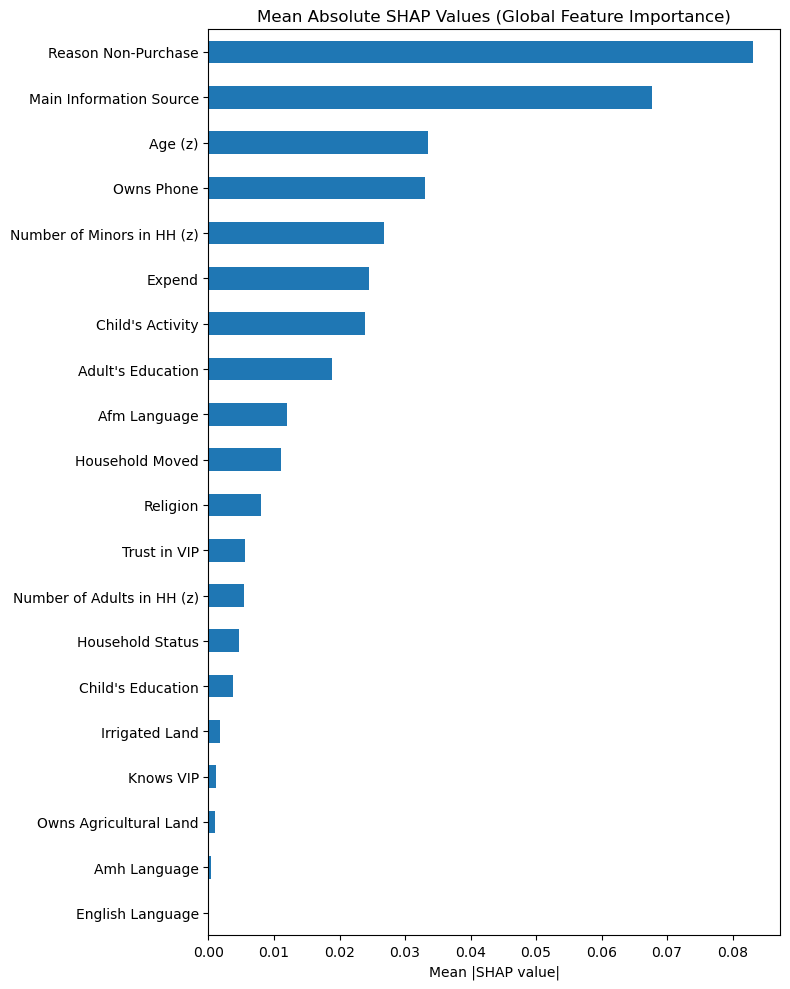

In [13]:
# Create Mean SHAP values across datapoints, effectively: Overall Feature Importancess
feature_importance = pd.Series(
    np.abs(shap_agg).mean(axis=0),
    index=shap_agg.columns
).sort_values(ascending=True)

feature_importance.plot(kind='barh', figsize=(8, 10))
plt.title('Mean Absolute SHAP Values (Global Feature Importance)')
plt.xlabel('Mean |SHAP value|')
plt.tight_layout()
plt.show()

In [14]:
# turn into dataframe, add column names and save
feature_importance = feature_importance.reset_index()
feature_importance.columns = ['feature', 'importance']

feature_importance
feature_importance.to_csv("feature_importance_svm_goat.csv", header=True, index=False)

# Refit using Education Variables as Numeric Variables

Goal: By (slightly) reducing the number of categorical variables, and increasing the number of numeric variables, the R2 might be increased. 

In [29]:
# load train and test data (previously created in the ElasticNet notebook)
train_goat = pd.read_csv("train_goat_df.csv")
test_goat = pd.read_csv("test_goat_df.csv")
# Prepare X and Y training sets for models
X_goat = train_goat.copy
X_goat = train_goat.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_goat", "cs_cs_ratio_post_goat", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults", "educ_recoded_constant", "educ_child_recoded",
                              "number_minors", "age_constant", "cs_diff_log"], axis=1)

Y_goat = train_goat["resid_mixed"]

X_goat_TEST = test_goat.copy
X_goat_TEST = test_goat.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_goat", "cs_cs_ratio_post_goat", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults", "educ_recoded_constant", "educ_child_recoded",
                              "number_minors", "age_constant", "cs_diff_log"], axis=1)

Y_goat_TEST = test_goat["resid_mixed"]
# Prepare categorical variables but creating dummies
X_goat = pd.get_dummies(X_goat, drop_first='True')
X_goat_TEST = pd.get_dummies(X_goat_TEST, drop_first='True')
X_goat_TEST.columns

Index(['expend', 'irrigated_land_bin', 'owns_phone', 'age_constant_z',
       'number_adults_z', 'number_minors_z', 'educ_child_z', 'educ_adult_z',
       'afm_language_Yes', 'agric_land_Yes', 'amh_language_Yes',
       'eng_language_Yes', 'activity_child_recoded_Not working',
       'activity_child_recoded_Student', 'activity_child_recoded_Working',
       'activity_child_recoded_Working with Livestock',
       'household_description_Not settled: The whole household moves around in order to herd the animals',
       'household_description_Partially settled: Some members of the household are permanently settled and others move around in order to herd their animals',
       'main_info_source_recoded_Media, Community-Based, and Survey Sources',
       'main_info_source_recoded_Professional and Organizational Sources',
       'religion_recoded_Muslim', 'religion_recoded_Traditional/Wakefata',
       'household_moved_Yes',
       'why_not_purchase_recoded_Distrust or Negative Perception',


In [ ]:
%%time
# Align columns in test set
#X_goat_TEST_encoded = X_goat_TEST_encoded.reindex(columns=X_goat_encoded.columns, fill_value=0)

# Define SVM model
svr = SVR()

# Define parameter grid for randomized search
param_grid = {
    'C': np.logspace(-2, 2, 20),            # regularization strength
    'epsilon': np.linspace(0.01, 1.0, 20),  # tolerance for error
    'kernel': ['rbf', 'linear'],            # two common kernels for regression
    'gamma': ['scale', 'auto']             # kernel coefficient
}

# Define custom scorer for MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Define 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform randomized search
svr = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_grid,
    n_iter=100,
    scoring={'mae': mae_scorer, 'r2': 'r2', 'mse': 'neg_mean_squared_error'},
    refit='mse',  # Refit the best model based on MAE
    cv=cv,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

#svr.fit(X_goat, Y_goat)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
CPU times: total: 4.8 s
Wall time: 4min 9s


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=SVR(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8...
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ]),
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['rbf', 'linear']},
                   refit='mse', return_train_score=True,
                   scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                            'mse': 'neg_mean_squared_error', 'r2': 'r2'},
                   verbose=1)

In [ ]:
# Pickle the model
#with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/'+'svr_m2_goatv1.pickle', 'wb') as to_write:
#    pickle.dump(svr, to_write)

In [32]:
# Read in pickled model (refit on r2)
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/' + 'svr_m2_goatv1.pickle', 'rb') as to_read:
    svrm2v1 = pickle.load(to_read)

print("Best hyperparameters:\n", svrm2v1.best_params_ , "\n")
print("Performance based on best hyperparameter specification:\n", svrm2v1.best_score_)

Best hyperparameters:
 {'kernel': 'linear', 'gamma': 'scale', 'epsilon': 0.9478947368421053, 'C': 0.04281332398719394} 

Performance based on best hyperparameter specification:
 -1.9090159452098991


In [33]:
# 3. Predict on the test set
y_predm2v1 = svrm2v1.predict(X_goat_TEST)

# 4. Evaluate performance
mae = mean_absolute_error(Y_goat_TEST, y_predm2v1)
mse = mean_squared_error(Y_goat_TEST, y_predm2v1)
r2  = r2_score(Y_goat_TEST, y_predm2v1)

print(f"Test Set Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE):  {np.sqrt(mse):.4f}")
print(f"R-squared (R²):            {r2:.4f}")

Test Set Performance:
Mean Absolute Error (MAE): 1.0287
Root Mean Squared Error (RMSE):  1.3693
R-squared (R²):            0.0106


In [34]:
# 1. Best model
best_model = svrm2v1.best_estimator_
best_model

SVR(C=0.04281332398719394, epsilon=0.9478947368421053, kernel='linear')

In [19]:
# 2. Explainer
X_sample = X_goat.sample(n=100, random_state=0)
explainer = shap.KernelExplainer(best_model.predict, X_sample)

In [20]:
# 3. Sample data (if large)
X_sample = X_goat.sample(n=100, random_state=0)
#shap_interaction_values = explainer.shap_interaction_values(X_goat)

# 4. Compute SHAP values
shap_values = explainer.shap_values(X_sample)

  0%|          | 0/100 [00:00<?, ?it/s]

c:\anaconda_custom\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


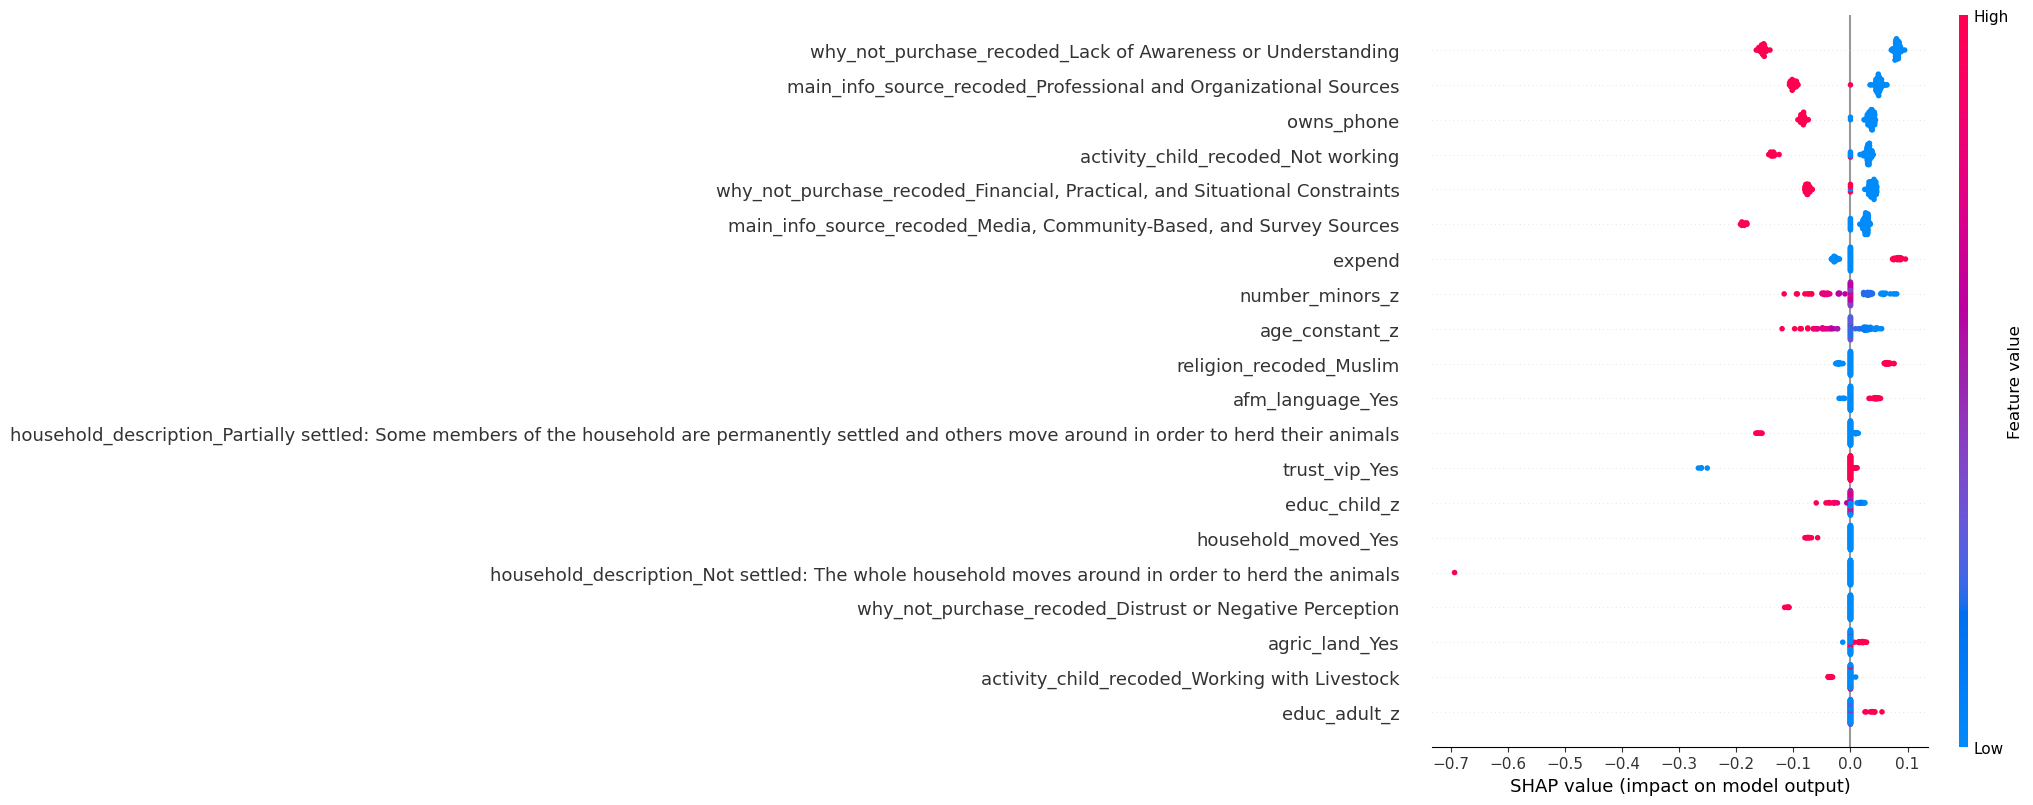

In [21]:
# Plot SHAP summary
shap.summary_plot(
    shap_values,
    X_sample,
    plot_type="dot",
)